#### Import Lib


In [37]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold, RandomizedSearchCV, cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Đọc dữ liệu


In [11]:
df_real = pd.read_csv('../Data/input_data.csv')
df = df_real.copy()

In [12]:
# Hàm loại bỏ giá trị ngoại lai
def remove_outliers(df, columns=None):
    """
    Loại bỏ giá trị ngoại lai khỏi các cột được chỉ định trong DataFrame.
    - df: DataFrame đầu vào
    - columns: Danh sách các cột cần kiểm tra (nếu None, sẽ kiểm tra tất cả các cột số)
    """
    if columns is None:
        columns = df.select_dtypes(include=['float', 'int']).columns  # Chỉ lấy các cột số

    for col in columns:
        # Tính IQR (Interquartile Range)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Xác định phạm vi hợp lệ
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Loại bỏ ngoại lai
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Áp dụng hàm
df = remove_outliers(df)

In [13]:
df.columns

Index(['Brand', 'Processor_Name', 'Processor_Brand', 'RAM', 'RAM_TYPE',
       'Display_type', 'GPU', 'GPU_Brand', 'SSD', 'OS', 'VRAM', 'Price_VND'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3034 entries, 0 to 3915
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Brand            3034 non-null   object
 1   Processor_Name   3034 non-null   object
 2   Processor_Brand  3034 non-null   object
 3   RAM              3034 non-null   int64 
 4   RAM_TYPE         3034 non-null   object
 5   Display_type     3034 non-null   object
 6   GPU              3034 non-null   object
 7   GPU_Brand        3034 non-null   object
 8   SSD              3034 non-null   int64 
 9   OS               3034 non-null   object
 10  VRAM             3034 non-null   int64 
 11  Price_VND        3034 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 308.1+ KB


#### Train - Test Split


In [15]:
# Giả sử dữ liệu của bạn có tên là df
X = df.drop('Price_VND', axis=1)  # Các biến độc lập
y = df['Price_VND']  # Biến mục tiêu

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Xác định biến số và biến phân loại
# Xác định các biến số và biến phân loại
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

#### Tạo Pipeline tiền xử lý


In [17]:
# Tạo pipeline cho tiền xử lý
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kết hợp các bước tiền xử lý vào ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### Xây dựng Pipeline cho mô hình hồi quy


In [18]:
# Danh sách các mô hình hồi quy
models = {
    'XGBRegressor': XGBRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'KNeighborsRegressor': KNeighborsRegressor()
}

# Huấn luyện và đánh giá mô hình
results = {}

for model_name, model in models.items():
    # Tạo pipeline cho mô hình
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Huấn luyện mô hình
    pipeline.fit(X_train, y_train)
    
    # Dự đoán trên tập train và tập test
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # # Đánh giá mô hình trên tập train
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Đánh giá mô hình trên tập test
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # # Lưu kết quả đánh giá
    results[model_name] = {
        'Train MAE': round(train_mae, 4), 'Test MAE': round(test_mae, 4),
        'Train MSE': round(train_mse, 4), 'Test MSE': round(test_mse, 4),
        'Train R2': round(train_r2, 4),   'Test R2': round(test_r2, 4)
    }
    # results[model_name] = {
    #     'MAE': test_mae,
    #     'MSE': test_mse,
    #     'R2': test_r2
    # }

# Hiển thị kết quả
results_df = pd.DataFrame(results).T
results_df


,Train MAE,Test MAE,Train MSE,Test MSE,Train R2,Test R2
XGBRegressor,1.566749e+06,2.207033e+06,4.822005e+12,9.270887e+12,0.8760,0.7706
DecisionTreeRegressor,8.022999e+05,2.703621e+06,2.454963e+12,1.500787e+13,0.9369,0.6287
RandomForestRegressor,1.271237e+06,2.377106e+06,3.384474e+12,1.104750e+13,0.9130,0.7267
LinearRegression,2.144549e+06,2.317085e+06,8.518286e+12,9.790896e+12,0.7810,0.7578
Ridge,2.192695e+06,2.308289e+06,8.695976e+12,9.788094e+12,0.7765,0.7578
KNeighborsRegressor,2.147893e+06,2.674143e+06,8.710604e+12,1.436497e+13,0.7761,0.6446


Phân tích từng mô hình:

XGBRegressor:

- **MAE**: \(2.21 \times 10^6\) (tốt trên tập kiểm tra).
- **MSE**: \(9.27 \times 10^{12}\) (thấp thứ hai trên tập kiểm tra).
- **R²**: 0.7706 (cao nhất trên tập kiểm tra).
- **Kết luận**: Hiệu suất cân bằng tốt giữa MAE, MSE và R².

DecisionTreeRegressor:

- **MAE**: \(2.70 \times 10^6\) (kém nhất trên tập kiểm tra).
- **MSE**: \(1.50 \times 10^{13}\) (cao nhất trên tập kiểm tra).
- **R²**: 0.6287 (thấp nhất trên tập kiểm tra).
- **Kết luận**: Overfitting nghiêm trọng, hiệu suất trên tập kiểm tra rất kém.

RandomForestRegressor:

- **MAE**: \(2.38 \times 10^6\) (thứ ba trên tập kiểm tra).
- **MSE**: \(1.10 \times 10^{13}\) (cao hơn XGBRegressor).
- **R²**: 0.7267 (thấp hơn XGBRegressor).
- **Kết luận**: Hiệu suất tốt nhưng không bằng XGBRegressor.

LinearRegression:

- **MAE**: \(2.32 \times 10^6\) (tốt thứ hai trên tập kiểm tra).
- **MSE**: \(9.79 \times 10^{12}\) (cao hơn XGBRegressor).
- **R²**: 0.7578 (thấp hơn XGBRegressor).
- **Kết luận**: Hiệu suất gần XGBRegressor nhưng không bằng.

Ridge:

- **MAE, MSE, R²**: Hiệu suất gần giống LinearRegression nhưng kém hơn một chút.
- **Kết luận**: Không tốt hơn LinearRegression hay XGBRegressor.

KNeighborsRegressor:

- **MAE**: \(2.67 \times 10^6\) (thứ tư trên tập kiểm tra).
- **MSE**: \(1.43 \times 10^{13}\) (cao hơn tất cả trừ DecisionTree).
- **R²**: 0.6446 (thấp).
- **Kết luận**: Hiệu suất thấp hơn nhiều so với XGBRegressor.

Kết luận:
**XGBRegressor** là mô hình tốt nhất vì:

1. MAE và MSE trên tập kiểm tra đều thấp.
2. R² trên tập kiểm tra cao nhất, cho thấy mô hình giải thích tốt nhất phương sai của dữ liệu.
3. Hiệu suất trên tập kiểm tra và huấn luyện tương đối cân bằng, không bị overfitting nghiêm trọng.

Hướng phát triển:

- Tối ưu tham số cho mô hình XGBRegressor


Tuy nhiên, XGBRegressor vẫn có dấu hiệu overfitting, mặc dù nó là mô hình tốt nhất trong số các mô hình đã so sánh.

Dấu hiệu overfitting:

- **Train MAE**: \(1.57 \times 10^6\) (rất thấp so với Test MAE: \(2.21 \times 10^6\)).
- **Train MSE**: \(4.82 \times 10^{12}\) (thấp hơn nhiều so với Test MSE: \(9.27 \times 10^{12}\)).
- **Train R²**: 0.8760 (cao hơn đáng kể so với Test R²: 0.7706).

Nguyên nhân của overfitting (có thể):

1. **Mô hình quá phức tạp:**

   - XGBRegressor có khả năng học rất mạnh, dẫn đến việc học quá kỹ các mẫu trong tập huấn luyện (gây overfitting).

2. **Cấu hình hyperparameters chưa tối ưu:**
   - Các tham số như: **n_estimators** (số lượng cây), **max_depth** (độ sâu của cây), **learning_rate** (tỷ lệ học), có thể cần được tinh chỉnh để giảm overfitting.


#### Đánh giá ban đầu cho mô hình XGBRegressor


Chạy mô hình mặc định


In [19]:
# Danh sách một số param cần lưu ý
xgb_params = {
    'n_estimators',        # Số lượng cây quyết định
    'learning_rate',       # Tốc độ học (eta)
    'max_depth',             # Độ sâu tối đa của cây
    'colsample_bytree',    # Tỷ lệ đặc trưng được chọn để huấn luyện mỗi cây
    'gamma',                 # Mức độ phạt để ngừng tạo nhánh
    'lambda',              # Regularization L2 (Ridge)
    'alpha'               # Regularization L1 (Lasso)
}


In [21]:
# Xây dựng Pipeline riêng cho mô hình XGBRegressor
XGB_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor())  # Mô hình XGBRegressor
    ]
)

# Huấn luyện lại mô hình với tham số mặc định
XGB_pipeline.fit(X_train, y_train)

# Dự đoán và đánh giá mô hình với tham số mặc định
y_pred = XGB_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# In ra các kết quả đánh giá và tham số mặc định
print("Kết quả đánh giá với tham số mặc định:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")
# XGB_pipeline.named_steps['regressor'].get_params()

# Tạo DataFrame từ y_test và y_pred
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})


# In ra các tham số có trong danh sách xgb_params
print("\nCác tham số của XGBRegressor trong danh sách cần lưu ý:")
xgb_model_params = XGB_pipeline.named_steps['regressor'].get_params()

for param in xgb_params:
    if param in xgb_model_params:
        print(f"{param}: {xgb_model_params[param]}")


Kết quả đánh giá với tham số mặc định:
MAE: 2207033.0366556835
MSE: 9270887279339.035
R²: 0.7706312012544468

Các tham số của XGBRegressor trong danh sách cần lưu ý:
learning_rate: None
gamma: None
colsample_bytree: None
n_estimators: None
max_depth: None


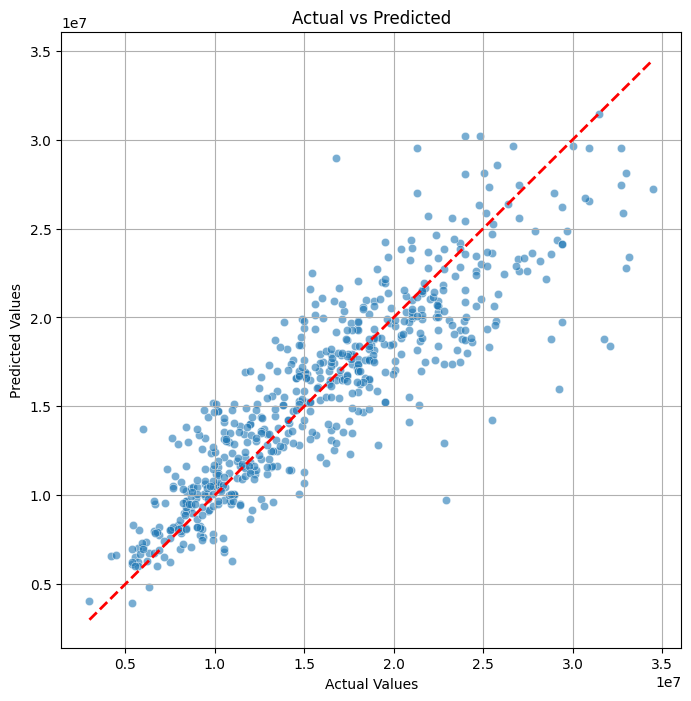

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x=results_df['Actual'], y=results_df['Predicted'], alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()], 
         color='red', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()


Những điểm tích cực:

- **Đường xu hướng dự đoán chính xác:**
  - Các điểm dữ liệu phần lớn nằm gần đường chéo màu đỏ (đường $y = x$), cho thấy mô hình dự đoán khá chính xác với giá trị thực tế.
- **Không có dấu hiệu rõ ràng của sai lệch (bias):**
  - Phân bố của các điểm trên biểu đồ không cho thấy sự thiên lệch rõ ràng, tức là mô hình không dự đoán quá thấp hoặc quá cao cho bất kỳ khoảng giá trị nào.
- **Độ phân tán hợp lý:**
  - Dữ liệu tập trung tương đối đồng đều xung quanh đường chéo, đặc biệt ở phần giữa (giá trị trung bình).

Những điểm cần cải thiện:

- **Phân tán tăng ở giá trị cao:**
  - Với các giá trị thực tế lớn (khoảng trên $2.5 \times 10^7$), dự đoán của mô hình có xu hướng phân tán xa hơn khỏi đường chéo, cho thấy hiệu suất dự đoán giảm ở phần này.
- **Outliers:**
  - Một số điểm dữ liệu nằm xa đường chéo, có thể là các outliers. Điều này cho thấy mô hình có thể gặp khó khăn trong việc dự đoán các giá trị bất thường.
- **Overfitting nhẹ:**
  - Dựa trên sự phân tán, có thể nghi ngờ rằng mô hình đang hơi quá khớp với dữ liệu huấn luyện, đặc biệt nếu giá trị trên tập kiểm tra kém hơn tập huấn luyện.


In [22]:
results_df

,Actual,Predicted
3699,24897000,21028382.0
2903,10267500,10410747.0
3105,24120000,18003924.0
490,11610000,13445709.0
1079,17697000,17854176.0
...,...,...
3442,11817000,13825256.0
3520,24297000,18837386.0
3176,13052100,17303804.0
799,12075000,14382863.0


Tối ưu mô hình mặc định bằng kiểm chứng chéo (k-fold cross validation)


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

# Xây dựng Pipeline cho XGBRegressor
XGB_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),  # Quy trình tiền xử lý
        ('regressor', XGBRegressor())   # Mô hình XGBRegressor
    ]
)

# Sử dụng KFold với 10 folds và shuffle dữ liệu
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Danh sách để lưu các giá trị MSE, MAE và R2 cho từng fold
mses = []
maes = []
r2s = []

# Vòng lặp qua các fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i + 1}:")  # Đánh số fold từ 1 để hiển thị

    # Chia dữ liệu thành tập huấn luyện và kiểm tra cho fold hiện tại
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Huấn luyện pipeline trên tập huấn luyện
    XGB_pipeline.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = XGB_pipeline.predict(X_test)

    # Tính toán các độ đo
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # In các độ đo cho fold hiện tại
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R-squared (R2) Score: {r2:.3f}")
    print()  # Xuống dòng cho phần in thông tin của fold tiếp theo

    # Lưu các độ đo vào danh sách
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)

# Tính toán và in ra giá trị trung bình của các độ đo trên tất cả các fold
mean_mse = sum(mses) / len(mses)
mean_mae = sum(maes) / len(maes)
mean_r2 = sum(r2s) / len(r2s)

print(f"Mean MSE across all folds: {mean_mse:.3f}")
print(f"Mean MAE across all folds: {mean_mae:.3f}")
print(f"Mean R2 across all folds: {mean_r2:.3f}")


Fold 1:
Mean Squared Error (MSE): 9348132164454.258
Mean Absolute Error (MAE): 2158781.641
R-squared (R2) Score: 0.777

Fold 2:
Mean Squared Error (MSE): 8619564961913.481
Mean Absolute Error (MAE): 2256055.441
R-squared (R2) Score: 0.775

Fold 3:
Mean Squared Error (MSE): 9276609987257.443
Mean Absolute Error (MAE): 2201422.801
R-squared (R2) Score: 0.772

Fold 4:
Mean Squared Error (MSE): 8829118439878.350
Mean Absolute Error (MAE): 2170847.538
R-squared (R2) Score: 0.755

Fold 5:
Mean Squared Error (MSE): 12246911767490.033
Mean Absolute Error (MAE): 2464197.521
R-squared (R2) Score: 0.709

Fold 6:
Mean Squared Error (MSE): 9875975190675.154
Mean Absolute Error (MAE): 2246466.699
R-squared (R2) Score: 0.770

Fold 7:
Mean Squared Error (MSE): 8893297116962.086
Mean Absolute Error (MAE): 2143913.936
R-squared (R2) Score: 0.764

Fold 8:
Mean Squared Error (MSE): 8888432160469.801
Mean Absolute Error (MAE): 2265693.260
R-squared (R2) Score: 0.737

Fold 9:
Mean Squared Error (MSE): 91087

Đánh giá mô hình từ kết quả kiểm chứng chéo
Hiệu suất trung bình khá tốt:

- Mean MSE: ~9.35 × 10¹², phản ánh mức độ sai số bình phương trung bình. Mặc dù con số lớn, nhưng nó phụ thuộc vào thang đo của dữ liệu đầu ra.
- Mean MAE: ~2.23 × 10⁶, cho thấy sai số trung bình tuyệt đối giữa giá trị dự đoán và giá trị thực.
- Mean R²: 0.760, nghĩa là mô hình giải thích được khoảng 76% phương sai của dữ liệu. Đây là kết quả khá ổn định.

Hiệu suất không đồng đều giữa các folds:

- Fold 5 có MSE lớn nhất (~1.22 × 10¹³) và R² thấp nhất (0.709), cho thấy một số fold có thể chứa dữ liệu khó dự đoán hơn.
- Sự dao động giữa các fold gợi ý rằng dữ liệu có thể không hoàn toàn đồng nhất, hoặc mô hình chưa tối ưu cho toàn bộ tập dữ liệu.

Mô hình chưa tối ưu:

- Mặc dù hiệu suất khá tốt, nhưng vẫn còn khoảng trống để cải thiện, đặc biệt khi xem xét sự dao động giữa các folds.


#### Tối ưu hóa tham số mô hình bằng RandomizedSearchCV


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Định nghĩa lưới tham số
params = {
    "n_estimators": range(100, 500, 50),
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    "max_depth": range(3, 21, 3),
    "gamma": [i / 10.0 for i in range(0, 5)],
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
}

# Tạo mô hình XGBRegressor
xgb_model = XGBRegressor()

# Thiết lập RandomizedSearchCV với verbose=2 để in quá trình tối ưu
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    n_iter=50,  # Số lần thử ngẫu nhiên
    scoring='neg_mean_absolute_error',  # Đánh giá theo MAE
    cv=10,  # Sử dụng 10-fold cross-validation
    verbose=2,  # Hiển thị quá trình tối ưu hóa
    random_state=42,
    n_jobs=-1  # Sử dụng tất cả các lõi CPU có sẵn
)

# Tạo pipeline với preprocessor và regressor
XGB_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('regressor', random_search)]
)

# Huấn luyện mô hình với RandomizedSearchCV
XGB_pipeline.fit(X_train, y_train)

# Dự đoán và đánh giá mô hình với tham số tối ưu
y_pred = XGB_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# In ra các kết quả đánh giá
print("Kết quả đánh giá với tham số tối ưu:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

# In ra các tham số tối ưu của mô hình
print("\nCác tham số tối ưu của mô hình XGBRegressor:")
print(random_search.best_params_)

# Tạo DataFrame từ y_test và y_pred
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Kết quả đánh giá với tham số tối ưu:
MAE: 2115966.5057755774
MSE: 8392495089704.112
R²: 0.7700165588507235

Các tham số tối ưu của mô hình XGBRegressor:
{'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.8}


Đánh giá chi tiết về 2 bộ tham số:

1. Kết quả với tham số mặc định:

- MAE (Mean Absolute Error): 2,207,033.0367
- MSE (Mean Squared Error): 9,270,887,279,339.035
- R²: 0.7706

2. Kết quả với tham số được điều chỉnh:

- MAE: 2,115,966.5058
- MSE: 8,392,495,089,704.112
- R²: 0.7700

Sau khi điều chỉnh tham số:

- MAE giảm từ 2,207,033.0367 xuống 2,115,966.5058 (~ giảm 4.13%).
- MSE giảm từ 9,270,887,279,339.035 xuống 8,392,495,089,704.112 (~ giảm 9.46%).
- R² giảm nhẹ từ 0.7706 xuống 0.7700 (~ giảm 0.08%).

Đánh giá:

- Điểm tích cực:
  - Việc điều chỉnh tham số giúp cải thiện hiệu suất mô hình trên các chỉ số lỗi (MAE và MSE). Điều này cho thấy mô hình đã dự đoán sát hơn với giá trị thực.
  - Giảm MSE một cách đáng kể là một thành công vì lỗi bình phương nhạy cảm với các giá trị ngoại lệ (outliers).
- Hạn chế:
  - Giá trị R2 giảm nhẹ (từ 0.7706 xuống 0.7700). Tuy nhiên, sự giảm này là rất nhỏ và có thể chấp nhận được vì mục tiêu là tối ưu hoá lỗi dự đoán.
  - Sự cải thiện ở MAE (giảm ~4%) chưa thật sự đột phá, có thể vì mô hình đã hoạt động khá tốt ngay từ đầu với tham số mặc định.

Kết luận:

- Việc điều chỉnh tham số đã giúp mô hình cải thiện hiệu suất, đặc biệt là giảm MSE. Tuy nhiên, mức độ cải thiện chưa quá đột phá.


#### Hướng phát triển


- **Xử lý dữ liệu (Data Preprocessing):**

  - Khai phá đặc trưng (Feature Engineering):
    - Tạo đặc trưng mới hoặc giảm chiều dữ liệu bằng PCA hoặc chọn lọc đặc trưng.

- **Điều chỉnh tham số (Hyperparameter Tuning):**
  - Mở rộng không gian tham số:
    - Thử nghiệm thêm các giá trị như `subsample` (0.5 - 0.9), `min_child_weight`, v.v.
  - Sử dụng Optuna hoặc Bayesian Optimization thay vì chỉ Grid Search để tối ưu nhanh hơn.
- **Thử nghiệm các mô hình khác:**

  - LightGBM: Nhanh hơn XGBoost trên các tập dữ liệu lớn.
  - CatBoost: Tốt cho dữ liệu phân loại (categorical features) mà không cần encoding.
  - Học tổ hợp (Ensemble Learning): Kết hợp XGBoost với Random Forest hoặc Linear Regression.

- **Điều chỉnh dữ liệu huấn luyện:**

  - Tăng dữ liệu (Data Augmentation): Tạo thêm dữ liệu vì tập dữ liệu hiện tại không đủ lớn.
  - Cross-validation sâu hơn: Dùng K-Fold với số lần gấp cao hơn (10-20 folds).

- **Thử mô hình Hybrid:**

  - Kết hợp Linear Regression và XGBoost:
    - Linear Regression để dự đoán xu hướng dài hạn, XGBoost dự đoán dao động ngắn hạn.
  - Exponential Smoothing và XGBoost:
    - Loại bỏ xu hướng dài hạn bằng phương pháp làm mịn, sau đó huấn luyện XGBoost trên phần dư.

- **Đánh giá và tối ưu hóa:**

  - Custom Loss Function: Sử dụng Huber Loss hoặc Quantile Loss để giảm ảnh hưởng của outliers.

- **Phân tích thêm:**
  - SHAP hoặc LIME: Hiểu rõ vai trò của từng đặc trưng trong dự đoán.
  - AutoML: Sử dụng các công cụ như H2O.ai hoặc Auto-sklearn để tự động thử nghiệm nhiều mô hình.


K=2: MAE=2356832.6684, MSE=10307982722506.9297, R2=0.7372
K=3: MAE=2319876.8403, MSE=10194849661002.7012, R2=0.7402
K=4: MAE=2272957.4906, MSE=9808443585104.7793, R2=0.7500
K=5: MAE=2279409.7247, MSE=9852135981685.6855, R2=0.7485
K=6: MAE=2252909.0619, MSE=9555859060923.4258, R2=0.7559
K=7: MAE=2251940.5727, MSE=9602106050178.5098, R2=0.7546
K=8: MAE=2253689.9403, MSE=9524835751948.4688, R2=0.7564
K=9: MAE=2238015.1254, MSE=9468976318741.5762, R2=0.7576
K=10: MAE=2221889.9330, MSE=9331093799363.0645, R2=0.7610
K=11: MAE=2245737.5424, MSE=9538178756404.0391, R2=0.7556
K=12: MAE=2221818.6669, MSE=9395068284777.3203, R2=0.7597
K=13: MAE=2238305.7594, MSE=9528606445532.3301, R2=0.7567
K=14: MAE=2233325.0517, MSE=9418734902873.5234, R2=0.7583
K=15: MAE=2218821.6388, MSE=9357021041239.4316, R2=0.7609


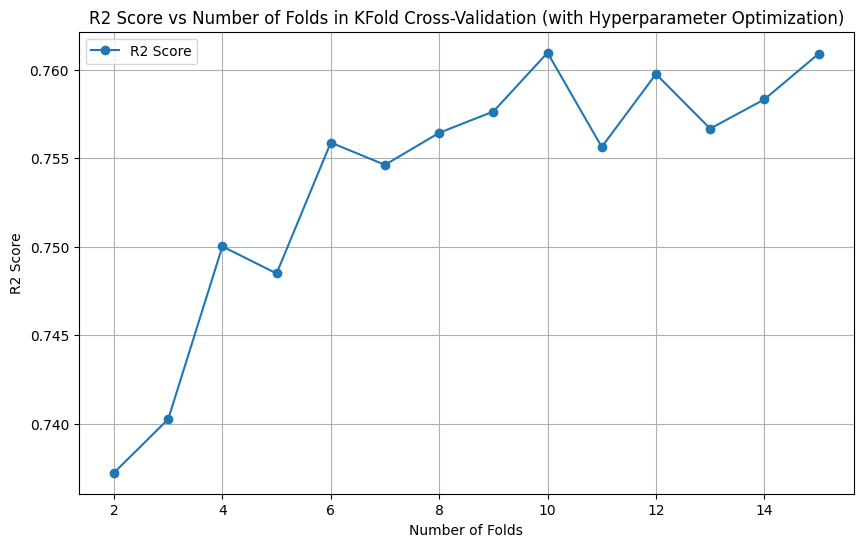

In [32]:
# from sklearn.model_selection import KFold, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np
# import matplotlib.pyplot as plt

# # Tạo DataFrame lưu kết quả
# kfold_results = []

# # Danh sách hyperparameters cần tối ưu hóa
# param_grid = {
#     'regressor__max_depth': [3, 5, 7],
#     'regressor__learning_rate': [0.01, 0.05, 0.1],
#     'regressor__n_estimators': [100, 200, 300],
#     'regressor__subsample': [0.8, 1.0],
#     'regressor__colsample_bytree': [0.8, 1.0]
# }

# # Vòng lặp qua số lượng folds từ 2 đến 15
# for num_folds in range(2, 16):
#     skf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
#     mae_scores = []
#     mse_scores = []
#     r2_scores = []

#     for train_index, test_index in skf.split(X, y):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         # Tối ưu hóa hyperparameters bằng GridSearchCV
#         grid_search = GridSearchCV(
#             estimator=XGB_pipeline,
#             param_grid=param_grid,
#             cv=3,  # Sử dụng 3-fold cross-validation trong GridSearchCV
#             scoring='r2',
#             n_jobs=-1  # Sử dụng tất cả các CPU khả dụng
#         )
#         grid_search.fit(X_train, y_train)

#         # Lấy pipeline tốt nhất sau tối ưu hóa
#         best_pipeline = grid_search.best_estimator_

#         # Dự đoán và đánh giá
#         y_pred = best_pipeline.predict(X_test)
#         mae_scores.append(mean_absolute_error(y_test, y_pred))
#         mse_scores.append(mean_squared_error(y_test, y_pred))
#         r2_scores.append(r2_score(y_test, y_pred))

#     # Lưu kết quả trung bình của từng số folds
#     kfold_results.append({
#         'num_folds': num_folds,
#         'mean_mae': np.mean(mae_scores),
#         'mean_mse': np.mean(mse_scores),
#         'mean_r2': np.mean(r2_scores)
#     })

# # In kết quả
# for result in kfold_results:
#     print(f"K={result['num_folds']}: MAE={result['mean_mae']:.4f}, MSE={result['mean_mse']:.4f}, R2={result['mean_r2']:.4f}")

# # (Tùy chọn) Vẽ biểu đồ sự thay đổi của R2 theo số lượng folds
# folds = [res['num_folds'] for res in kfold_results]
# r2_values = [res['mean_r2'] for res in kfold_results]

# plt.figure(figsize=(10, 6))
# plt.plot(folds, r2_values, marker='o', label='R2 Score')
# plt.title('R2 Score vs Number of Folds in KFold Cross-Validation (with Hyperparameter Optimization)')
# plt.xlabel('Number of Folds')
# plt.ylabel('R2 Score')
# plt.grid(True)
# plt.legend()
# plt.show()


In [47]:
# Hàm dự đoán giá bán laptop
def predict_laptop_price(brand, processor_name, processor_brand, ram, ram_type, display_type, gpu, gpu_brand, ssd, os, vram):
    # Tạo DataFrame cho dữ liệu nhập
    input_data = pd.DataFrame({
        'Brand': [brand],
        'Processor_Name': [processor_name],
        'Processor_Brand': [processor_brand],
        'RAM': [ram],
        'RAM_TYPE': [ram_type],
        'Display_type': [display_type],
        'GPU': [gpu],
        'GPU_Brand': [gpu_brand],
        'SSD': [ssd],
        'OS': [os],
        'VRAM': [vram]
    })
    
    # Dự đoán giá bán
    predicted_price = XGB_pipeline.predict(input_data)
    return predicted_price[0]

# Ví dụ sử dụng hàm
predicted_price = predict_laptop_price(
    brand='Lenovo', processor_name='Intel Core i5 (11th Gen)', processor_brand='Intel', ram=8, ram_type='DDR4', 
    display_type='LCD', gpu='Geforce RTX 3050', gpu_brand='NVIDIA', ssd=512, os='Windows 10', vram=6
)

print(f"Giá bán dự đoán của laptop là: {predicted_price} VND")

Giá bán dự đoán của laptop là: 20391932.0 VND
